# Library import

In [3]:
import os
import subprocess
import time

import yaml
from sklearn.model_selection import GroupKFold

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
import torch.nn as nn

from pathlib import Path
import json
from collections import defaultdict, Counter
import random
import random
import shutil
from tqdm import tqdm
import zipfile
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
%pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics 8.3.58 🚀 Python-3.10.14 torch-2.4.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6037.6/8062.4 GB disk)


# Path

In [17]:
COCO_JSON_NM = 'COCO_annotations_new.json'
OUT_COCO_JSON_NM = 'mod_COCO_annotations.json'
OUT_IMAGE_FLDR_NM = 'images'
TRAIN_NM = 'train'
VAL_NM = 'val'
TEST_NM = 'test'
LABEL_NM = 'labels'
YAML = 'dataset.yaml'
RANDOM_SEED = 2023

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
yolo_dataset_pth = Path('/kaggle/input/yolodataset-xview')
out_dataset_pth = Path('/kaggle/working/')
txt_fldr = "/kaggle/input/predicted-labels"
img_fldr = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')

coco_json_pth = in_dataset_pth / COCO_JSON_NM
new_coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM

train_img = yolo_dataset_pth / TRAIN_NM / OUT_IMAGE_FLDR_NM
val_img = yolo_dataset_pth / VAL_NM / OUT_IMAGE_FLDR_NM
test_img = yolo_dataset_pth / TEST_NM / OUT_IMAGE_FLDR_NM
train_txt = yolo_dataset_pth / TRAIN_NM / LABEL_NM
val_txt = yolo_dataset_pth / VAL_NM / LABEL_NM 
test_txt = yolo_dataset_pth / TEST_NM / LABEL_NM  
dataset_yaml = yolo_dataset_pth / YAML

In [ ]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)

# Utility

In [ ]:
def load_json(file_path):
    """
    Carica un file JSON dal percorso specificato.

    :param file_path: Percorso al file JSON da caricare.
    :return: Dati contenuti nel file JSON (come dizionario o lista).
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# COCO Preprocessing

In [ ]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    """
    # Leggi il JSON dal file di input
    data = load_json(input_path)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []
 
    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")
 
    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)
 
    # Elenco di annotazioni da mantenere (solo quelle valide)
    valid_annotations = []
    annotations_to_remove = set()
 
    # Controllo dei bounding box
    for annotation in tqdm(data.get('annotations', []), desc="Processing Annotations"):
        
        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])
        
        x, y, width, height = annotation['bbox']
        xmin, xmax = x, x + width
        ymin, ymax = y, y + height
        
        # Verifica che xmin < xmax e ymin < ymax, e che la larghezza e altezza siano sufficienti
        if xmin >= xmax or ymin >= ymax or width <= 10 or height <= 10:
            annotations_to_remove.add(annotation['id'])
        else:
            annotation['bbox'] = [xmin, ymin, xmax, ymax]
            valid_annotations.append(annotation)
 
    # Rimuovi le annotazioni non valide
    data['annotations'] = valid_annotations
 
    # Ordina le categorie per ID
    categories = sorted(categories, key=lambda x: x['id'])
    
    # Aggiorna le categorie nel JSON
    data['categories'] = categories

 
    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

In [ ]:
process_custom_coco_json(coco_json_pth, new_coco_json_pth)

### Category Check

In [ ]:
def count_bounding_boxes(json_path):
    """
    Conta il numero di bounding box per ogni categoria in un file COCO JSON.

    Args:
        json_path (str): Percorso del file JSON.

    Returns:
        list: Elenco di tuple con ID categoria, nome categoria e numero di bounding box.
    """
    # Carica il file JSON
    coco_data = load_json(json_path)

    # Estrarre i dati principali
    annotations = coco_data.get("annotations", [])
    categories = coco_data.get("categories", [])

    # Mappare id di categoria ai nomi delle categorie
    category_id_to_name = {category["id"]: category["name"] for category in categories}

    # Contare i bounding box per categoria
    bbox_counts = defaultdict(int)
    for annotation in annotations:
        category_id = annotation["category_id"]
        bbox_counts[category_id] += 1

    # Creare un elenco dei risultati
    results = [
        (cat_id, category_id_to_name.get(cat_id, "Unknown"), count)
        for cat_id, count in bbox_counts.items()
    ]
    
    # Ordinare i risultati in ordine decrescente per numero di bounding box
    results.sort(key=lambda x: x[2], reverse=True)
    
    # Stampare i risultati
    for cat_id, category_name, count in results:
        print(f"Categoria ID {cat_id} ('{category_name}'): {count} bounding box")

In [ ]:
count_bounding_boxes(new_coco_json_pth)

# JSON to YOLO

In [ ]:
def convert_json_to_yolo(json_path, images_dir, output_dir, input_dir, train_dir_out, val_dir_out, test_dir_out, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Carica il file JSON
    with open(json_path) as f:
        data = json.load(f)

    # Mappa le classi
    class_mapping = {category['id']: category['name'] for category in data['categories']}
    nc = len(class_mapping)  # Numero di classi

    # Crea le cartelle per il dataset
    train_images_dir = os.path.join(output_dir, 'train', 'images')
    val_images_dir = os.path.join(output_dir, 'val', 'images')
    test_images_dir = os.path.join(output_dir, 'test', 'images')

    train_labels_dir = os.path.join(output_dir, 'train', 'labels')
    val_labels_dir = os.path.join(output_dir, 'val', 'labels')
    test_labels_dir = os.path.join(output_dir, 'test', 'labels')
    
    for dir_path in [train_images_dir, val_images_dir, test_images_dir, train_labels_dir, val_labels_dir, test_labels_dir]:
        os.makedirs(dir_path, exist_ok=True)

    # Dividi le immagini in training, validation, and test
    images = data['images']
    random.shuffle(images)
    total_images = len(images)
    
    train_split = int(train_ratio * total_images)
    val_split = int((train_ratio + val_ratio) * total_images)

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    # Funzione per copiare le immagini in una cartella specifica
    def copy_images(image_list, target_dir):
        for image in tqdm(image_list, desc=f"Copying images to {target_dir}", unit="image"):
            src_path = os.path.join(images_dir, image['file_name'])
            dst_path = os.path.join(target_dir, image['file_name'])
            shutil.copy(src_path, dst_path)

    # Copia le immagini nelle rispettive cartelle
    copy_images(train_images, train_images_dir)
    copy_images(val_images, val_images_dir)
    copy_images(test_images, test_images_dir)

    # Converte le annotazioni in formato YOLO e salva nei file di testo
    def convert_annotations(image, annotations, target_dir):
        image_id = image['id']
        image_width = image['width']
        image_height = image['height']
        image_name = image['file_name']

        label_file_path = os.path.join(target_dir, f"{image_name.replace('.jpg', '.txt')}")
        label_dir = os.path.dirname(label_file_path)

        # Crea la cartella se non esiste
        os.makedirs(label_dir, exist_ok=True)

        with open(label_file_path, 'w') as label_file:
            for annotation in annotations:
                if annotation['image_id'] == image_id:
                    category_id = annotation['category_id']
                    xmin, ymin, xmax, ymax = annotation['bbox']

                    # Normalizza le coordinate
                    x_center = (xmin + xmax) / 2 / image_width
                    y_center = (ymin + ymax) / 2 / image_height
                    width = (xmax - xmin) / image_width
                    height = (ymax - ymin) / image_height

                    # Scrivi nel file di annotazione
                    label_file.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

    # Converte le annotazioni per ogni immagine e le salva nelle cartelle appropriate
    def process_images(image_list, target_dir, label_target_dir):
        for image in tqdm(image_list, desc=f"Converting annotations", unit="image"):
            annotations = [annotation for annotation in data['annotations'] if annotation['image_id'] == image['id']]
            convert_annotations(image, annotations, label_target_dir)

    # Processa le immagini per training, validation e test
    process_images(train_images, 'train', train_labels_dir)
    process_images(val_images, 'val', val_labels_dir)
    process_images(test_images, 'test', test_labels_dir)
        
    # Crea il file YAML per YOLO
    yaml_content = f"""path: {input_dir}
train: {train_dir_out}  # train images
val: {val_dir_out}  # val images
test: {test_dir_out}  # test images

# Classes
nc: {nc}  # number of classes
names:
"""
    # Aggiungi le classi al file YAML
    for idx, class_name in class_mapping.items():
        yaml_content += f"  {int(idx)}: {class_name}\n"  # Assicurati che l'indice sia numerico senza virgolette

    # Scrivi il file YAML
    with open(os.path.join(output_dir, 'dataset.yaml'), 'w') as yaml_file:
        yaml_file.write(yaml_content.strip())

    print("Conversione e split completati.")

In [ ]:
convert_json_to_yolo(
    json_path=new_coco_json_pth,
    images_dir=img_fldr,
    output_dir=out_dataset_pth,
    input_dir=yolo_dataset_pth,
    train_dir_out=train_img,
    val_dir_out=val_img,
    test_dir_out=test_img,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
)

In [ ]:
# Nome del file zip da creare
zip_file_name = "YOLO_dataset.zip"

# Elenco di file e cartelle da includere nello zip
items_to_zip = [
    "test",
    "train",
    "val",
    "dataset.yaml",
]

# Funzione per aggiungere file e cartelle allo zip
def zip_folder(zipf, folder_path, base_folder=""):
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, base_folder)
            zipf.write(file_path, arcname)

# Creazione dello zip
with zipfile.ZipFile(zip_file_name, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for item in items_to_zip:
        if os.path.exists(item):  # Verifica che il file o la cartella esista
            if os.path.isdir(item):  # Se è una cartella, aggiungi tutto il contenuto
                zip_folder(zipf, item, out_dataset_pth)
            else:  # Se è un file, aggiungilo direttamente
                zipf.write(item)
        else:
            print(f"Elemento non trovato: {item}")

## Check Yaml

In [ ]:
def analyze_yolo_dataset(yaml_path):
    # Carica il file YAML
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    # Estraggo le informazioni dal file YAML
    base_path = data['path']
    sets = ['train', 'val', 'test']
    stats = {}
    
    total_images = 0
    total_bboxes = Counter()
    class_names = data['names']

    for dataset_set in sets:
        images_path = os.path.join(base_path, dataset_set)
        labels_path = os.path.join(base_path, dataset_set, 'labels')

        # Controlla se le directory esistono
        if not os.path.exists(images_path) or not os.path.exists(labels_path):
            print(f"Directory per il set '{dataset_set}' non trovata.")
            continue

        # Conta immagini
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg'))]
        num_images = len(image_files)
        total_images += num_images
        
        stats[dataset_set] = {"images": num_images, "bbox": Counter()}

        # Conta bounding box con tqdm
        print(f"Analizzando {dataset_set}...")
        for label_file in tqdm(os.listdir(labels_path), desc=f"Contando bbox in {dataset_set}", unit="file"):
            label_path = os.path.join(labels_path, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    class_id = line.split()[0]  # La classe è il primo elemento della riga
                    stats[dataset_set]["bbox"][class_id] += 1
                    total_bboxes[class_id] += 1

    return stats, total_images, total_bboxes, class_names

# Funzione per mostrare i risultati con le percentuali calcolate per set
def print_stats(stats, total_images, total_bboxes, class_names):
    print("\n--- ANALISI COMPLESSIVA ---")
    print(f"Totale immagini: {total_images}")
    print(f"Distribuzione complessiva delle categorie:")
    
    # Ordina le classi in base al numero di bbox, dal più grande al più piccolo
    sorted_bboxes = sorted(total_bboxes.items(), key=lambda x: x[1], reverse=True)
    
    for class_id, count in sorted_bboxes:
        percentage = (count / sum(total_bboxes.values())) * 100
        print(f"  Classe {class_names[int(class_id)]} ({class_id}): {count} bbox ({percentage:.2f}%)")
    
    print("\n--- ANALISI PER SET ---")
    
    total_bboxes_all_sets = 0  # Per calcolare il totale complessivo dei bbox
    for dataset_set, data in stats.items():
        images_percentage = (data['images'] / total_images) * 100 if total_images > 0 else 0
        print(f"\n--- {dataset_set.upper()} ---")
        print(f"Numero di immagini: {data['images']} ({images_percentage:.2f}%)")
        print("Distribuzione categorie:")
        
        # Calcola il totale dei bbox per ogni set
        total_bboxes_in_set = sum(data['bbox'].values())
        total_bboxes_all_sets += total_bboxes_in_set  # Aggiungi al totale complessivo
        
        # Ordina le classi per ogni set in base al numero di bbox
        sorted_set_bboxes = sorted(data['bbox'].items(), key=lambda x: x[1], reverse=True)
        
        for class_id, count in sorted_set_bboxes:
            percentage = (count / total_bboxes_in_set) * 100 if total_bboxes_in_set > 0 else 0
            print(f"  Classe {class_names[int(class_id)]} ({class_id}): {count} bbox ({percentage:.2f}%)")
        
        print("Totale bounding box:", total_bboxes_in_set, f"({(total_bboxes_in_set / sum(total_bboxes.values())) * 100:.2f}%)")

    # Aggiungi la percentuale per il totale complessivo dei bounding box
    print("\n--- TOTALE COMPLESSIVO ---")
    print(f"Totale bounding box: {total_bboxes_all_sets}")

In [ ]:
# Esegui analisi
stats, total_images, total_bboxes, class_names = analyze_yolo_dataset(dataset_yaml)
print_stats(stats, total_images, total_bboxes, class_names)

# YoloV11

## Training

In [ ]:
# Pretrained Model
model = YOLO('yolo11n.pt') 

# Configurazione del training
results = model.train(
    data=dataset_yaml,     # Path al file YAML del dataset
    epochs=100,            # Numero di epoche
    batch=16,              # Dimensione del batch
    imgsz=640,             # Dimensione delle immagini (640x640)
    lr0=0.01,              # Learning rate iniziale
    lrf=0.1,               # Fattore di decay del learning rate ((riduce da 0.01 a 0.001))
    save=True,             # Salva i pesi migliori
    #optimizer='AdamW',    
    optimizer = 'SGD',
    momentum=0.9,          # Momentum ottimizzato
    freeze=[0, 1, 2]       # Congela i primi tre livelli (backbone)
    #project='my_model_results'  # si può personalizzare la directory di salvataggio dei pesi
)

### Creazione zip 

In [ ]:
# Nome del file zip da creare
zip_file_name = "SGD_decay_predict.zip"

# Percorso della cartella da includere nello zip
folder_to_zip = "/kaggle/working/predict2"  

# Funzione per aggiungere file e cartelle allo zip
def zip_folder(zipf, folder_path, base_folder=""):
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, base_folder)  # Percorso relativo per preservare la struttura
            zipf.write(file_path, arcname)

# Creazione dello zip
if os.path.exists(folder_to_zip):  # Verifica che la cartella esista
    with zipfile.ZipFile(zip_file_name, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
        zip_folder(zipf, folder_to_zip, base_folder=folder_to_zip)
    print(f"Archivio zip creato: {zip_file_name}")
else:
    print(f"Cartella non trovata: {folder_to_zip}")

### Riprendere addestramento da pesi salvati

In [ ]:
# Carica il modello con i pesi precedenti
model = YOLO('/kaggle/input/sgd-84/pytorch/default/1/last.pt') 

# Configura il training
results = model.train(
    data=dataset_yaml,            # Percorso al dataset YAML
    epochs=100,                    
    batch=16,                     # Dimensione del batch
    imgsz=640,                    # Dimensione delle immagini
    lr0=0.01,                     # Learning rate iniziale
    lrf=0.1,                      # Fattore di decay del learning rate (riduce da 0.01 a 0.001)
    optimizer='SGD',              # Ottimizzatore
    momentum=0.9,                 # Momentum
    freeze=[0,1,2],
    save=True,                    # Salva i nuovi pesi
    resume=True                   # Indica di riprendere l'addestramento
)

## Validazione

In [ ]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt') # carica i pesi salvati (senza si considera il modello dell'ultima epoca)
model.eval()
results = model.val(data=dataset_yaml) 

## Test

In [ ]:
model = YOLO('/kaggle/input/yolo_best_model/pytorch/default/1/best.pt')
results = model.predict(test_img, imgsz=416, conf = 0.4, iou = 0.5, save_conf = True, save = True, save_txt = True, project = out_dataset_pth, verbose = False)

# Images with predicted labels

In [ ]:
def draw_bboxes_on_images(image_list, image_folder, txt_folder, output_folder=None):
    """
    Disegna i bounding box sulle immagini in base ai file txt corrispondenti.

    Args:
        image_list (list): Lista di nomi delle immagini (es. ["image1.jpg", "image2.png"]).
        image_folder (str): Percorso alla cartella delle immagini.
        txt_folder (str): Percorso alla cartella dei file txt.
        output_folder (str, opzionale): Cartella di output per salvare le immagini con i bounding box.
    """
    if output_folder and not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Creiamo un dizionario di colori unici per ciascuna categoria
    category_colors = {
        0: (255, 0, 0),   # Red for category 0
        1: (0, 128, 0),   # Verde scuro for category 1
        2: (0, 0, 255),   # Blue for category 2
        3: (255, 255, 0), # Yellow for category 3
        4: (0, 255, 255), # Cyan for category 4
        5: (255, 0, 255), # Magenta for category 5
        6: (128, 0, 128), # Viola for category 6
        7: (0, 0, 128),   # Blu scuro for category 7
        8: (0, 255, 0),   # Verde for category 8
        9: (128, 0, 0),   # Marrone for category 9
        10:(128, 128, 0), # Oliva for category 10
    }

    for image_name in image_list:
        image_path = os.path.join(image_folder, image_name)
        txt_path = os.path.join(txt_folder, os.path.splitext(image_name)[0] + ".txt")

        if not os.path.exists(image_path):
            print(f"Immagine non trovata: {image_path}")
            continue

        if not os.path.exists(txt_path):
            print(f"File txt non trovato: {txt_path}")
            continue

        # Carica l'immagine
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Leggi i dati dal file txt
        with open(txt_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            data = line.strip().split()
            category_id, x_min, y_mid, width, height = map(float, data)

            # Converti le coordinate relative in assolute
            img_height, img_width, _ = image.shape
            abs_x_min = int((x_min - width / 2) * img_width)
            abs_y_min = int((y_mid - height / 2) * img_height)
            abs_width = int(width * img_width)
            abs_height = int(height * img_height)

            # Calcola l'angolo opposto del bbox
            abs_x_max = abs_x_min + abs_width
            abs_y_max = abs_y_min + abs_height

            # Scegli il colore in base alla categoria (se non esiste, usa il rosso di default)
            color = category_colors.get(int(category_id), (255, 0, 0))

            # Disegna il rettangolo e la label sull'immagine
            cv2.rectangle(image, (abs_x_min, abs_y_min), (abs_x_max, abs_y_max), color, 2)  # Spessore 2

            # Posizione del testo vicino al bounding box
            text_x = abs_x_min
            text_y = abs_y_min - 5  # Spostiamo il testo più vicino al bounding box

            # Disegnare il testo con il colore della categoria 
            cv2.putText(
                image,
                str(int(category_id)),
                (text_x, text_y),  # Posizione del testo
                cv2.FONT_HERSHEY_COMPLEX_SMALL,
                1,  # Dimensione del font 
                color,  # Colore del testo (lo stesso del bounding box)
                1,  # Spessore del testo
                lineType=cv2.LINE_AA  # Migliore antialiasing
            )

        # Mostra l'immagine 
        plt.figure(figsize=(6, 6))  # Dimensioni più piccole
        plt.imshow(image)
        plt.axis("off")
        plt.title(image_name)
        plt.show()

        # Salva l'immagine se è specificata una cartella di output
        if output_folder:
            output_path = os.path.join(output_folder, image_name)
            cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [ ]:
# Esempio di utilizzo
image_list = ["img_2618_1280_1600.jpg", "img_2618_2560_1280.jpg", "img_2608_2880_640.jpg", "img_2591_2240_1280.jpg"]
draw_bboxes_on_images(image_list, img_fldr, txt_folder)

## Plot Loss

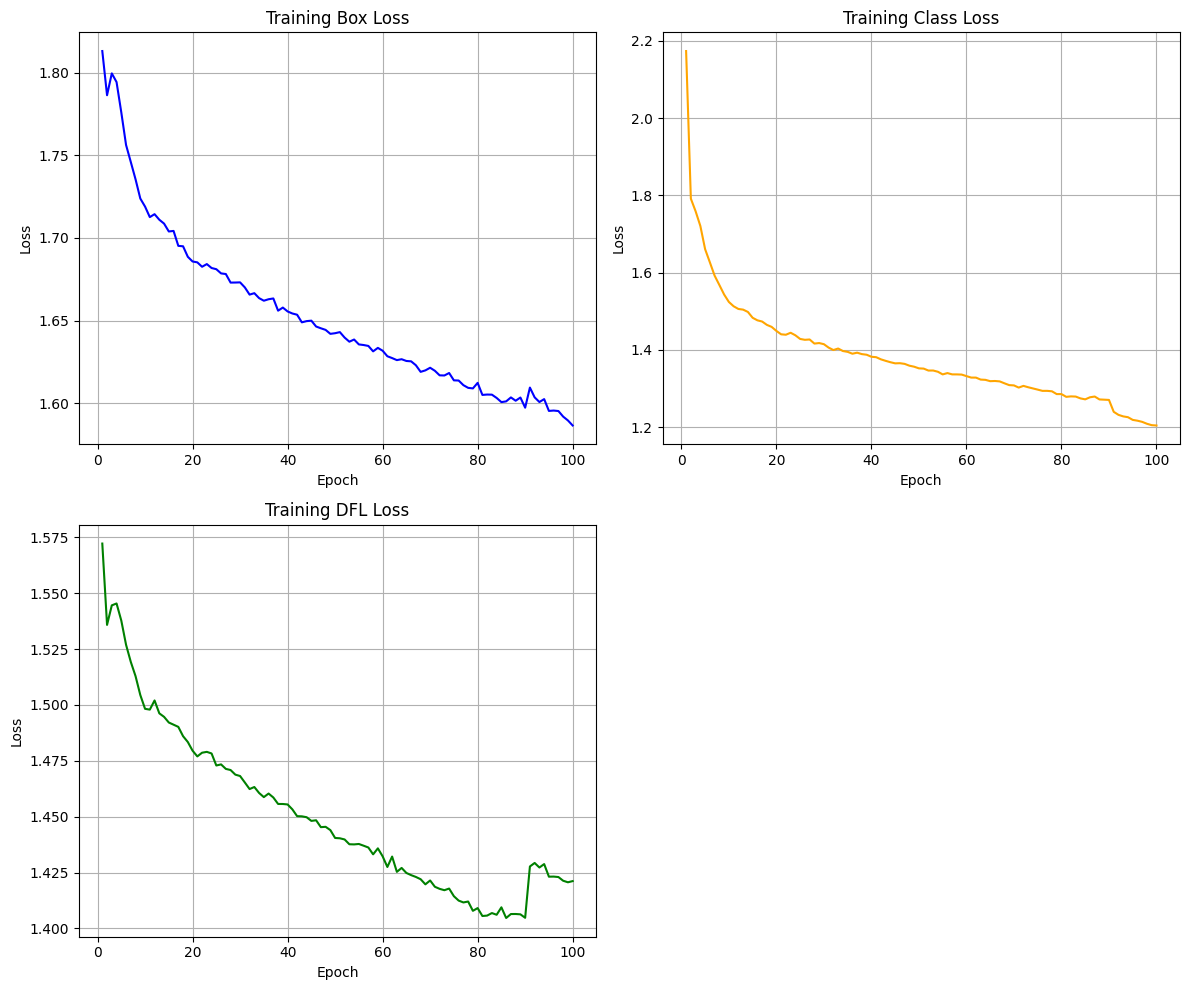

In [5]:
def plot_loss_functions(file1, file2, file3):
    # Carica i dati dai tre file
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)

    # Combina i dati
    data = pd.concat([data1, data2, data3], ignore_index=True)
    
    # Crea il grafico per le perdite di allenamento (loss)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot per 'box_loss'
    axs[0, 0].plot(data['epoch'], data['train/box_loss'], label='Train Box Loss', color='blue')
    axs[0, 0].set_title('Training Box Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid(True)
    
    # Plot per 'cls_loss'
    axs[0, 1].plot(data['epoch'], data['train/cls_loss'], label='Train Class Loss', color='orange')
    axs[0, 1].set_title('Training Class Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].grid(True)
    
    # Plot per 'dfl_loss'
    axs[1, 0].plot(data['epoch'], data['train/dfl_loss'], label='Train DFL Loss', color='green')
    axs[1, 0].set_title('Training DFL Loss')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].grid(True)

    # Rimuoviamo il grafico per mAP e miglioriamo la disposizione dei grafici
    axs[1, 1].axis('off')  # Nascondiamo l'ultima sottofigura
    
    # Migliora la disposizione dei grafici
    plt.tight_layout()
    
    # Mostra i grafici
    plt.show()

# Esegui la funzione con i tre file txt come input
file1 = '/kaggle/input/results-loss/result_1_11.csv'  # Inserisci il percorso del primo file (epoche 1-11)
file2 = '/kaggle/input/results-loss/results_12_84.csv' # Inserisci il percorso del secondo file (epoche 12-84)
file3 = '/kaggle/input/results-loss/results_85_100.csv' # Inserisci il percorso del terzo file (epoche 85-100)
plot_loss_functions(file1, file2, file3)

# Confusion Matrix

## Check Test

In [23]:
def count_txt_files_and_lines(directory):
    # Inizializza i contatori
    empty_files_count = 0
    non_empty_files_count = 0
    total_lines_count = 0
    
    # Scansiona tutti i file nella directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        # Controlla se è un file .txt
        if filename.endswith(".txt") and os.path.isfile(file_path):
            # Controlla se il file è vuoto
            if os.path.getsize(file_path) == 0:
                empty_files_count += 1
            else:
                non_empty_files_count += 1
                
                # Conta il numero di righe nel file non vuoto
                with open(file_path, 'r') as file:
                    total_lines_count += sum(1 for line in file)

    return empty_files_count, non_empty_files_count, total_lines_count

In [24]:
directory_path = '/kaggle/input/yolodataset-xview/test/labels'  # Sostituisci con il percorso della tua cartella
empty_files, non_empty_files, total_lines = count_txt_files_and_lines(directory_path)

print(f"Numero di file .txt vuoti: {empty_files}")
print(f"Numero di file .txt non vuoti: {non_empty_files}")
print(f"Numero totale di righe nei file .txt: {total_lines}") #numero di labels

directory_path = '/kaggle/input/predicted-labels'  # Sostituisci con il percorso della tua cartella
empty_files, non_empty_files, total_lines = count_txt_files_and_lines(directory_path)

print(f"Numero di file .txt vuoti: {empty_files}")
print(f"Numero di file .txt non vuoti: {non_empty_files}")
print(f"Numero totale di righe nei file .txt: {total_lines}") #numero di labels

Numero di file .txt vuoti: 1512
Numero di file .txt non vuoti: 3078
Numero totale di righe nei file .txt: 49391
Numero di file .txt vuoti: 0
Numero di file .txt non vuoti: 2896
Numero totale di righe nei file .txt: 44263


In [37]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def iou(bbox1, bbox2):
    """Calcola l'Intersection over Union (IoU) tra due bounding boxes."""
    # Calcolo le coordinate dei bounding box
    x1_min = bbox1[0] - bbox1[2] / 2
    y1_min = bbox1[1] - bbox1[3] / 2
    x1_max = bbox1[0] + bbox1[2] / 2
    y1_max = bbox1[1] + bbox1[3] / 2
    
    x2_min = bbox2[0] - bbox2[2] / 2
    y2_min = bbox2[1] - bbox2[3] / 2
    x2_max = bbox2[0] + bbox2[2] / 2
    y2_max = bbox2[1] + bbox2[3] / 2
    
    # Intersezione
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)
    
    # Area di intersezione
    inter_area = max(0, x_inter_max - x_inter_min) * max(0, y_inter_max - y_inter_min)
    
    # Unione
    bbox1_area = (x1_max - x1_min) * (y1_max - y1_min)
    bbox2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = bbox1_area + bbox2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

def calculate_confusion_matrix(true_labels_folder, predicted_labels_folder, num_classes, background_index=11, iou_threshold=0.5):
    # La matrice di confusione include l'indice del background
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)  # Matrice di dimensioni num_classes x num_classes
    
    true_files = set(os.listdir(true_labels_folder))
    pred_files = set(os.listdir(predicted_labels_folder))

    for true_file in true_files:
        # Leggi il file delle etichette vere
        true_file_path = os.path.join(true_labels_folder, true_file)
        with open(true_file_path, 'r') as f:
            true_bboxes = [list(map(float, line.strip().split())) for line in f.readlines()]

        # Se il file delle etichette vere è vuoto, è solo background
        true_is_background = len(true_bboxes) == 0
        
        # Se il file delle etichette predette non esiste, il modello ha predetto background
        pred_file_path = os.path.join(predicted_labels_folder, true_file)
        pred_is_background = not os.path.exists(pred_file_path)

        if true_is_background and pred_is_background:
            # Caso di vero positivo per background
            confusion_matrix[background_index, background_index] += 1
        elif true_is_background and not pred_is_background:
            # Caso di falso positivo per background (modello ha predetto oggetti)
            with open(pred_file_path, 'r') as f:
                pred_bboxes = [list(map(float, line.strip().split())) for line in f.readlines()]
            for pred in pred_bboxes:
                pred_class = int(pred[0])
                confusion_matrix[background_index, pred_class] += 1
        elif not true_is_background and pred_is_background:
            # Caso di falso negativo per background (modello ha predetto background ma ci sono oggetti)
            confusion_matrix[background_index, background_index] += 1
        else:
            # Se ci sono oggetti veri e predizioni non vuote
            with open(pred_file_path, 'r') as f:
                pred_bboxes = [list(map(float, line.strip().split())) for line in f.readlines()]
            
            true_assigned = [False] * len(true_bboxes)
            for pred in pred_bboxes:
                pred_class = int(pred[0])
                best_iou = 0
                best_idx = -1
                for idx, true in enumerate(true_bboxes):
                    iou_value = iou(pred[1:], true[1:])
                    if iou_value > best_iou:
                        best_iou = iou_value
                        best_idx = idx
                
                # Se l'IoU è maggiore della soglia, è un vero positivo per quella classe
                if best_iou >= iou_threshold and not true_assigned[best_idx]:
                    confusion_matrix[pred_class, int(true_bboxes[best_idx][0])] += 1
                    true_assigned[best_idx] = True
                else:
                    confusion_matrix[pred_class, background_index] += 1  # Falso positivo per background
            
            # Gestisci i falsi negativi (quando una classe vera non è stata predetta)
            for idx, assigned in enumerate(true_assigned):
                if not assigned:
                    confusion_matrix[int(true_bboxes[idx][0]), background_index] += 1  # Falso negativo per background
    
    return confusion_matrix

# Usa la funzione
true_labels_folder = '/kaggle/input/yolodataset-xview/test/labels'
predicted_labels_folder = '/kaggle/input/predicted-labels'
num_classes = 12  # Definisci il numero di classi nel tuo modello

conf_matrix = calculate_confusion_matrix(true_labels_folder, predicted_labels_folder, num_classes)
print(conf_matrix)

[[   90     0     0     0     0     0     1     0     0     0     0    64]
 [    0  5489   384     0     0     3    13     0     0     2     0  7269]
 [    0    82   872     3     0    36    25     0     1     4     0  1712]
 [    0     1     6   223     0     0     1     0     0     0     0   173]
 [    0     1     0     0   385     4     5     0     0     0     0   288]
 [    0     1    33     0     0   118     5     0     0     0     0   310]
 [    0    22     9     0     2     3 22115     0     3     2     0 22602]
 [    0     0     0     0     0     0     0     0     0     0     0    11]
 [    0     1     0     0     1     0     2     0    82     0     0    63]
 [    0     0     2     1     1     0     6     0     0    69     0   268]
 [    0     0     0     0     0     0     0     0     0     0    15    27]
 [    4    22     7     1     5     9    48     6     3     0     5  1694]]


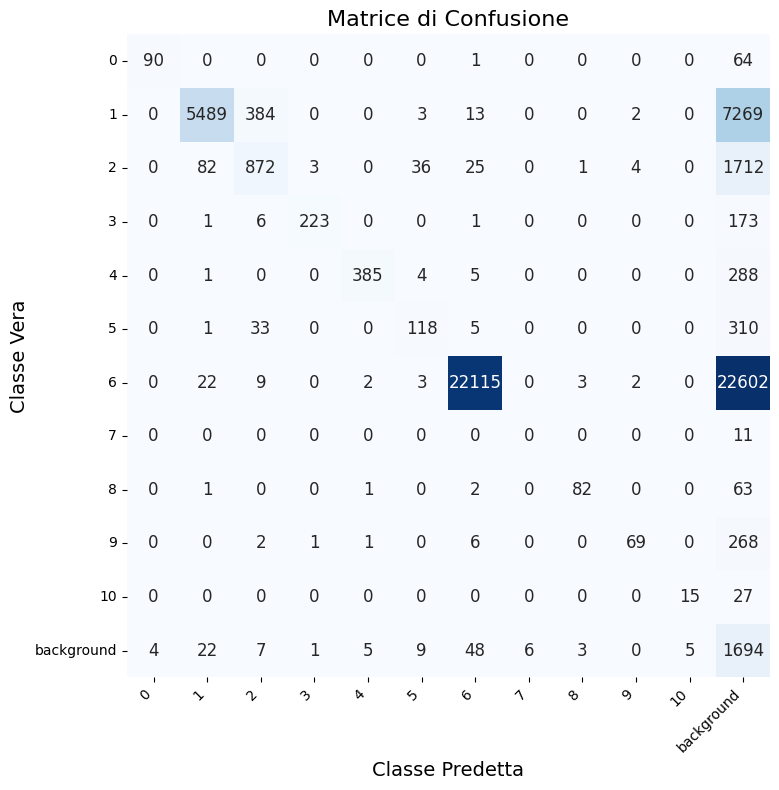

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(conf_matrix, class_names, cmap='Blues'):
    """
    Plotta la matrice di confusione con una heatmap.
    
    :param conf_matrix: matrice di confusione
    :param class_names: lista di nomi delle classi (compreso 'background' se necessario)
    :param cmap: mappa di colori per la heatmap
    """
    plt.figure(figsize=(10, 8))  # Imposta le dimensioni della figura
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, 
                     xticklabels=class_names, yticklabels=class_names,
                     cbar=False, annot_kws={'size': 12}, square=True)
    
    plt.title('Matrice di Confusione', fontsize=16)
    plt.xlabel('Classe Predetta', fontsize=14)
    plt.ylabel('Classe Vera', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Esempio di nomi delle classi (includi il background se è presente)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'background']

# Chiamata per plottare la matrice di confusione
plot_confusion_matrix(conf_matrix, class_names)


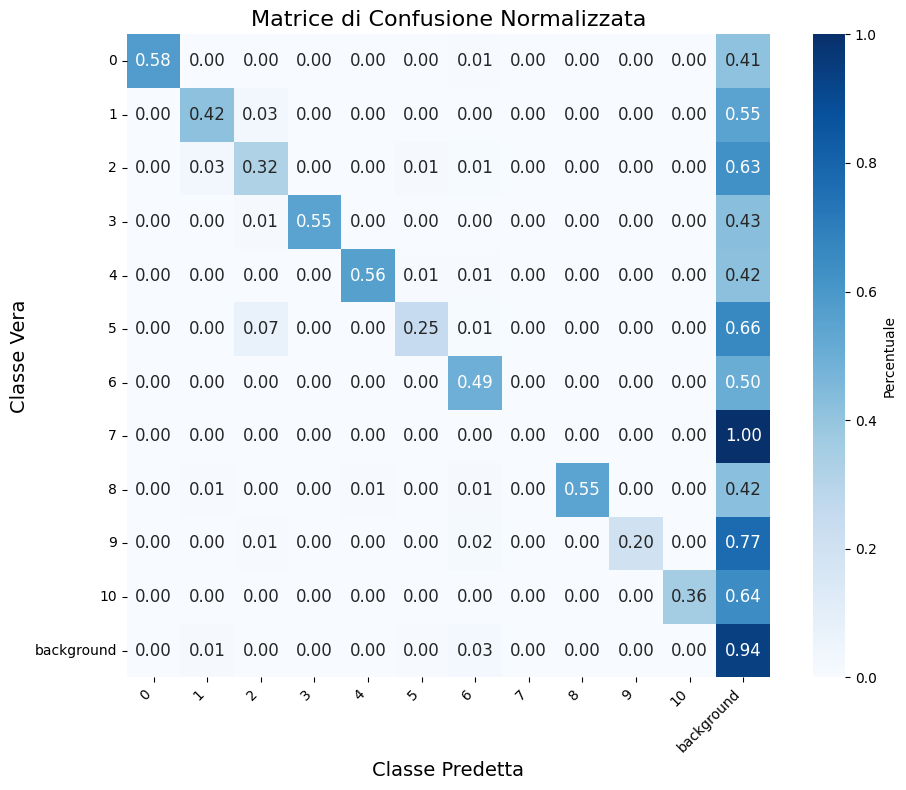

In [40]:
def plot_normalized_confusion_matrix(conf_matrix, class_names, cmap='Blues'):
    """Plotta la matrice di confusione normalizzata."""
    # Normalizza la matrice di confusione: ogni elemento della riga è diviso per la somma della riga stessa
    conf_matrix_normalized = conf_matrix.astype('float')  # Converte in float per poter eseguire la divisione
    row_sums = conf_matrix_normalized.sum(axis=1, keepdims=True)  # Somma per ogni riga
    conf_matrix_normalized /= row_sums  # Dividi ogni riga per la sua somma
    
    # Visualizza la matrice normalizzata come heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, 
                     xticklabels=class_names, yticklabels=class_names,
                     cbar_kws={'label': 'Percentuale'}, annot_kws={'size': 12}, square=True)
    
    plt.title('Matrice di Confusione Normalizzata', fontsize=16)
    plt.xlabel('Classe Predetta', fontsize=14)
    plt.ylabel('Classe Vera', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Esempio di uso:
# Utilizza la matrice di confusione calcolata precedentemente
plot_normalized_confusion_matrix(conf_matrix, class_names)
